Function Definitions for Using QAOA_run
（QAOA_runを使用するための関数の諸定義）

In [1]:
import typing
import qokit
import numpy as np
import scipy
import time
from qokit.fur.qaoa_simulator_base import QAOAFastSimulatorBase, TermsType

'''
This will serve as a module for QAOA simulation functionalities. 

The main function is QAOA_run, which uses QAOA with specified parameters for the ising model 
that it is passed. 

Most other functions are written only for the purpose of QAOA_run to use them. 
'''

def get_simulator(N: int, terms: TermsType, sim_or_none: QAOAFastSimulatorBase | None = None) -> QAOAFastSimulatorBase:
    if sim_or_none is None:
        simclass = qokit.fur.choose_simulator(name="auto")
        return simclass(N, terms=terms)
    else:
        return sim_or_none


def get_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    if result is None:
        simulator = get_simulator(N, terms, sim)
        return simulator.simulate_qaoa(gamma, beta)
    else:
        return result


def get_simulator_and_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> tuple[QAOAFastSimulatorBase, np.ndarray]:
    simulator = get_simulator(N, terms, sim)
    if result is None:
        result = get_result(N, terms, gamma, beta, simulator)
    return (simulator, result)


def get_state(N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None):
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_statevector(result)


def get_probabilities(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_probabilities(result, preserve_state=True)


def get_expectation(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_expectation(result, preserve_state=True)


def get_overlap(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_overlap(result, preserve_state=True)


def inverse_objective_function(ising_model: TermsType, N: int, p: int, mixer: str, states: list[np.ndarray] | None) -> typing.Callable:
    def inverse_objective(*args) -> float:
        gamma, beta = args[0][:p], args[0][p:]
        simulator, result = get_simulator_and_result(N, ising_model, gamma, beta)
        expectation = get_expectation(N, ising_model, gamma, beta, simulator, result)

        if states is not None:
            states.append(get_state(N, ising_model, gamma, beta, simulator, result))

        return -expectation

    return inverse_objective


def QAOA_run(
    ising_model: TermsType,
    N: int,
    p: int,
    init_gamma: np.ndarray,
    init_beta: np.ndarray,
    optimizer_method: str = 'COBYLA',
    optimizer_options: dict | None = None,
    mixer: str = "x",  # Using a different mixer is not yet supported
    states: list[np.ndarray] | None = None,
) -> dict:
    init_freq = np.hstack([init_gamma, init_beta]) 
    #call_counter = [0]  #not needed; use result.nit instead 

    start_time = time.time()
    result = scipy.optimize.minimize(
        inverse_objective_function(ising_model, N, p, mixer, states), init_freq, method=optimizer_method, options=optimizer_options
    ) 
    #the above returns a scipy optimization result object that has multiple attributes
    #result.x gives the optimal solutionsol.success #bool whether algorithm succeeded
    #result.message #message of why algorithms terminated
    #result.nfev is number of iterations used (here, number of QAOA calls)
    end_time = time.time()

    gamma, beta = result.x[:p], result.x[p:]

    return {
        "gamma": gamma,
        "beta": beta,
        "state": get_state(N, ising_model, gamma, beta),
        "expectation": get_expectation(N, ising_model, gamma, beta),
        "overlap": get_overlap(N, ising_model, gamma, beta),
        "runtime": end_time - start_time,  # measured in seconds
        "num_QAOA_calls": result.nfev,
        "classical_opt_success": result.success,
        "scipy_opt_message": result.message
    }

Let's create a 2D graph of QAOA runtime versus N and try to predict the trend.
（QAOAのRunTimeとNについて２次元グラフを作成して、その傾向を予測してみよう。）

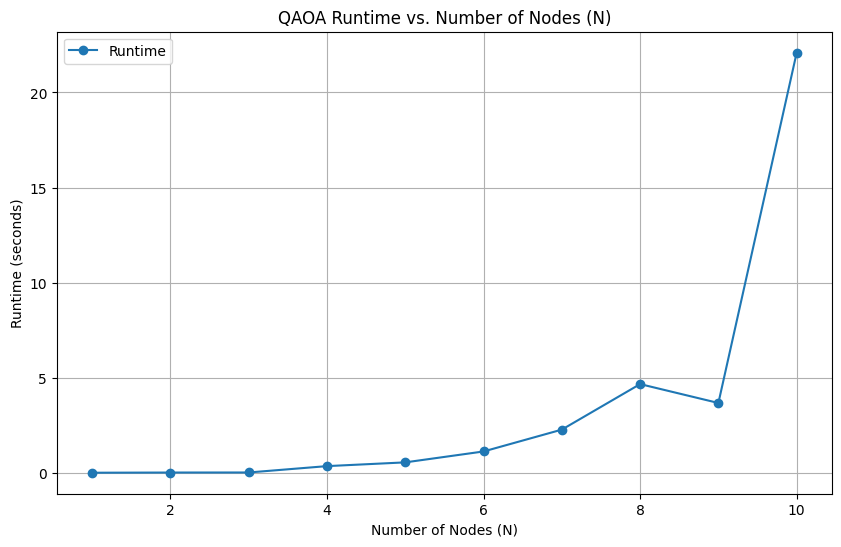

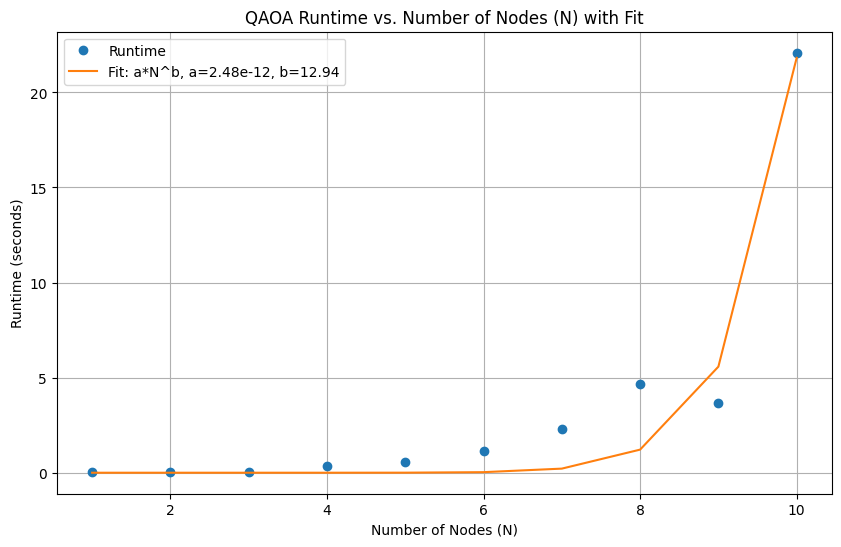

近似関数のパラメータ: a = 2.48e-12, b = 12.94


In [2]:
import typing
import qokit
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
import networkx as nx
from qokit.fur.qaoa_simulator_base import QAOAFastSimulatorBase, TermsType

# QAOA用の関数定義
def get_simulator(N: int, terms: TermsType, sim_or_none: QAOAFastSimulatorBase | None = None) -> QAOAFastSimulatorBase:
    if sim_or_none is None:
        simclass = qokit.fur.choose_simulator(name="auto")
        return simclass(N, terms=terms)
    else:
        return sim_or_none

def get_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    if result is None:
        simulator = get_simulator(N, terms, sim)
        return simulator.simulate_qaoa(gamma, beta)
    else:
        return result

def get_simulator_and_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> tuple[QAOAFastSimulatorBase, np.ndarray]:
    simulator = get_simulator(N, terms, sim)
    if result is None:
        result = get_result(N, terms, gamma, beta, simulator)
    return (simulator, result)

def get_state(N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None):
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_statevector(result)

def get_probabilities(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_probabilities(result, preserve_state=True)

def get_expectation(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_expectation(result, preserve_state=True)

def get_overlap(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_overlap(result, preserve_state=True)

def inverse_objective_function(ising_model: TermsType, N: int, p: int, mixer: str, states: list[np.ndarray] | None) -> typing.Callable:
    def inverse_objective(*args) -> float:
        gamma, beta = args[0][:p], args[0][p:]
        simulator, result = get_simulator_and_result(N, ising_model, gamma, beta)
        expectation = get_expectation(N, ising_model, gamma, beta, simulator, result)

        if states is not None:
            states.append(get_state(N, ising_model, gamma, beta, simulator, result))

        return -expectation

    return inverse_objective

def QAOA_run(
    ising_model: TermsType,
    N: int,
    p: int,
    init_gamma: np.ndarray,
    init_beta: np.ndarray,
    optimizer_method: str = 'COBYLA',
    optimizer_options: dict | None = None,
    mixer: str = "x",  # Using a different mixer is not yet supported
    states: list[np.ndarray] | None = None,
) -> dict:
    init_freq = np.hstack([init_gamma, init_beta]) 

    start_time = time.time()
    result = scipy.optimize.minimize(
        inverse_objective_function(ising_model, N, p, mixer, states), init_freq, method=optimizer_method, options=optimizer_options
    ) 
    end_time = time.time()

    gamma, beta = result.x[:p], result.x[p:]

    return {
        "gamma": gamma,
        "beta": beta,
        "state": get_state(N, ising_model, gamma, beta),
        "expectation": get_expectation(N, ising_model, gamma, beta),
        "overlap": get_overlap(N, ising_model, gamma, beta),
        "runtime": end_time - start_time,  # measured in seconds
        "num_QAOA_calls": result.nfev,
        "classical_opt_success": result.success,
        "scipy_opt_message": result.message
    }

# Max-Cut Ising Modelを生成する関数
def generate_maxcut_ising_terms(G: nx.Graph) -> TermsType:
    terms = []
    for i, j in G.edges():
        terms.append((-1, (i, j)))  # Max-CutのIsingモデルのためのJij=-1
    return terms

# QAOA実行と結果のプロット
p = 5  # QAOAのステップ数
num_samples = 10  # Nの最大値

# ランダムグラフの生成とQAOAの実行、実行時間の記録
runtimes = []
Ns = range(1, num_samples + 1)

for N in Ns:
    G = nx.erdos_renyi_graph(N, 0.5)
    ising_model = generate_maxcut_ising_terms(G)
    init_gamma, init_beta = np.random.rand(2, p)
    qaoa_result = QAOA_run(ising_model, N, p, init_gamma, init_beta, "COBYLA")
    runtimes.append(qaoa_result["runtime"])

# Nと実行時間のグラフをプロット
plt.figure(figsize=(10, 6))
plt.plot(Ns, runtimes, 'o-', label="Runtime")
plt.xlabel("Number of Nodes (N)")
plt.ylabel("Runtime (seconds)")
plt.title("QAOA Runtime vs. Number of Nodes (N)")
plt.legend()
plt.grid(True)
plt.show()

# 近似関数のフィッティング
def fit_function(N, a, b):
    return a * N ** b

# データのフィッティング
params, _ = scipy.optimize.curve_fit(fit_function, Ns, runtimes)

# フィッティング結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(Ns, runtimes, 'o', label="Runtime")
plt.plot(Ns, fit_function(np.array(Ns), *params), '-', label=f"Fit: a*N^b, a={params[0]:.2e}, b={params[1]:.2f}")
plt.xlabel("Number of Nodes (N)")
plt.ylabel("Runtime (seconds)")
plt.title("QAOA Runtime vs. Number of Nodes (N) with Fit")
plt.legend()
plt.grid(True)
plt.show()

# パラメータの表示
print(f"近似関数のパラメータ: a = {params[0]:.2e}, b = {params[1]:.2f}")


Using seed results in the following code.
（seedを使用すると以下のようなコードになる。）

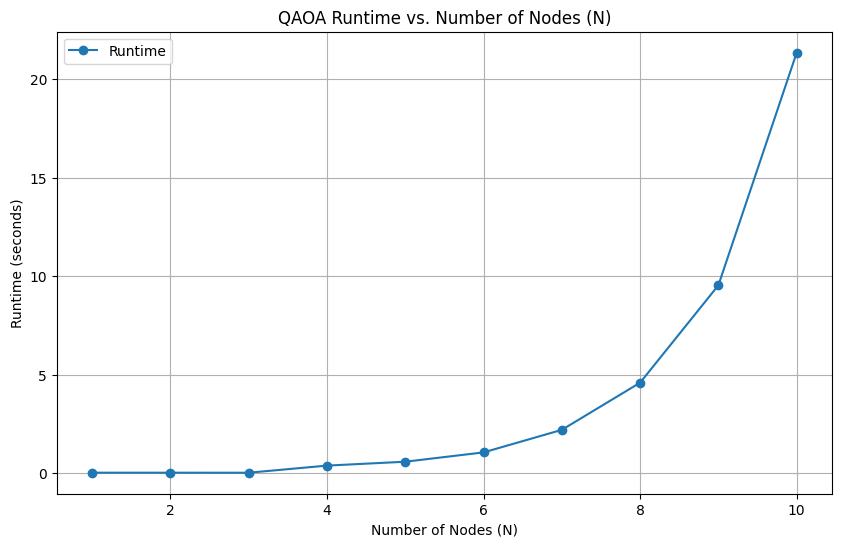

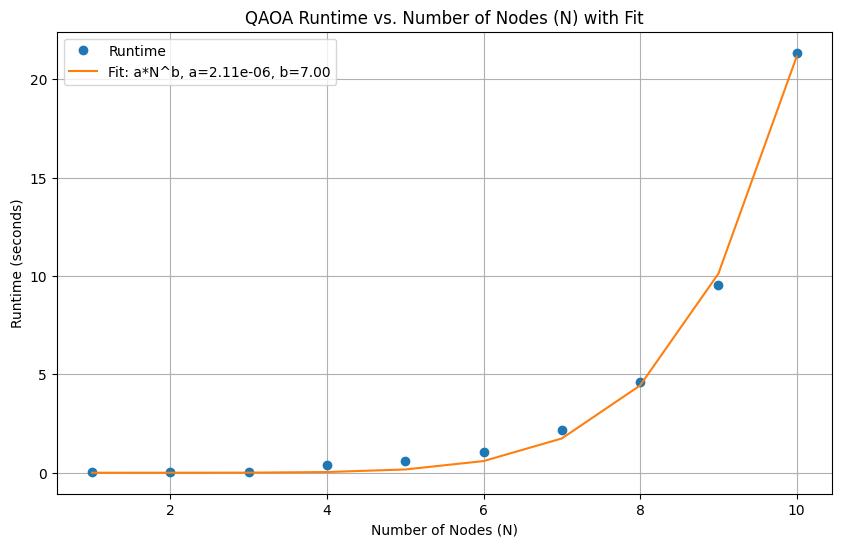

近似関数のパラメータ: a = 2.11e-06, b = 7.00


In [7]:
import typing
import qokit
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
import networkx as nx
from qokit.fur.qaoa_simulator_base import QAOAFastSimulatorBase, TermsType

# ランダムシードの設定
np.random.seed(0)

# QAOA用の関数定義
def get_simulator(N: int, terms: TermsType, sim_or_none: QAOAFastSimulatorBase | None = None) -> QAOAFastSimulatorBase:
    if sim_or_none is None:
        simclass = qokit.fur.choose_simulator(name="auto")
        return simclass(N, terms=terms)
    else:
        return sim_or_none

def get_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    if result is None:
        simulator = get_simulator(N, terms, sim)
        return simulator.simulate_qaoa(gamma, beta)
    else:
        return result

def get_simulator_and_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> tuple[QAOAFastSimulatorBase, np.ndarray]:
    simulator = get_simulator(N, terms, sim)
    if result is None:
        result = get_result(N, terms, gamma, beta, simulator)
    return (simulator, result)

def get_state(N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None):
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_statevector(result)

def get_probabilities(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_probabilities(result, preserve_state=True)

def get_expectation(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_expectation(result, preserve_state=True)

def get_overlap(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_overlap(result, preserve_state=True)

def inverse_objective_function(ising_model: TermsType, N: int, p: int, mixer: str, states: list[np.ndarray] | None) -> typing.Callable:
    def inverse_objective(*args) -> float:
        gamma, beta = args[0][:p], args[0][p:]
        simulator, result = get_simulator_and_result(N, ising_model, gamma, beta)
        expectation = get_expectation(N, ising_model, gamma, beta, simulator, result)

        if states is not None:
            states.append(get_state(N, ising_model, gamma, beta, simulator, result))

        return -expectation

    return inverse_objective

def QAOA_run(
    ising_model: TermsType,
    N: int,
    p: int,
    init_gamma: np.ndarray,
    init_beta: np.ndarray,
    optimizer_method: str = 'COBYLA',
    optimizer_options: dict | None = None,
    mixer: str = "x",  # Using a different mixer is not yet supported
    states: list[np.ndarray] | None = None,
) -> dict:
    init_freq = np.hstack([init_gamma, init_beta]) 

    start_time = time.time()
    result = scipy.optimize.minimize(
        inverse_objective_function(ising_model, N, p, mixer, states), init_freq, method=optimizer_method, options=optimizer_options
    ) 
    end_time = time.time()

    gamma, beta = result.x[:p], result.x[p:]

    return {
        "gamma": gamma,
        "beta": beta,
        "state": get_state(N, ising_model, gamma, beta),
        "expectation": get_expectation(N, ising_model, gamma, beta),
        "overlap": get_overlap(N, ising_model, gamma, beta),
        "runtime": end_time - start_time,  # measured in seconds
        "num_QAOA_calls": result.nfev,
        "classical_opt_success": result.success,
        "scipy_opt_message": result.message
    }

# Max-Cut Ising Modelを生成する関数
def generate_maxcut_ising_terms(G: nx.Graph) -> TermsType:
    terms = []
    for i, j in G.edges():
        terms.append((-1, (i, j)))  # Max-CutのIsingモデルのためのJij=-1
    return terms

# QAOA実行と結果のプロット
p = 5  # QAOAのステップ数
num_samples = 10  # Nの最大値

# ランダムグラフの生成とQAOAの実行、実行時間の記録
runtimes = []
Ns = range(1, num_samples + 1)

for N in Ns:
    G = nx.erdos_renyi_graph(N, 0.5)
    ising_model = generate_maxcut_ising_terms(G)
    init_gamma, init_beta = np.random.rand(2, p)
    qaoa_result = QAOA_run(ising_model, N, p, init_gamma, init_beta, "COBYLA")
    runtimes.append(qaoa_result["runtime"])

# Nと実行時間のグラフをプロット
plt.figure(figsize=(10, 6))
plt.plot(Ns, runtimes, 'o-', label="Runtime")
plt.xlabel("Number of Nodes (N)")
plt.ylabel("Runtime (seconds)")
plt.title("QAOA Runtime vs. Number of Nodes (N)")
plt.legend()
plt.grid(True)
plt.show()

# 近似関数のフィッティング
def fit_function(N, a, b):
    return a * N ** b

# データのフィッティング
params, _ = scipy.optimize.curve_fit(fit_function, Ns, runtimes)

# フィッティング結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(Ns, runtimes, 'o', label="Runtime")
plt.plot(Ns, fit_function(np.array(Ns), *params), '-', label=f"Fit: a*N^b, a={params[0]:.2e}, b={params[1]:.2f}")
plt.xlabel("Number of Nodes (N)")
plt.ylabel("Runtime (seconds)")
plt.title("QAOA Runtime vs. Number of Nodes (N) with Fit")
plt.legend()
plt.grid(True)
plt.show()

# パラメータの表示
print(f"近似関数のパラメータ: a = {params[0]:.2e}, b = {params[1]:.2f}")
